<a href="https://colab.research.google.com/github/MaxDixx/AutoEncoder/blob/main/autoencoder_AndhikaRachmatFauzi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import kagglehub
import shutil
from math import log10
import numpy as np

# 1. Download dataset dari KaggleHub
path = kagglehub.dataset_download("ckay16/accident-detection-from-cctv-footage")
print("Path to dataset files:", path)

# 2. Pindahkan semua gambar ke folder 'frames'
frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)

image_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith((".jpg", ".png")):
            src_path = os.path.join(root, file)
            dst_path = os.path.join(frames_dir, file)
            shutil.copy(src_path, dst_path)
            image_paths.append(dst_path)

print(f"Copied {len(image_paths)} images to '{frames_dir}'")

# 3. Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 4. Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 5. Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        print(f"{len(self.image_files)} images found in '{image_dir}'")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image

# 6. Load dataset
dataset = CustomImageDataset(frames_dir, transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 7. Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 8. Inisialisasi model
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 9. Training
os.makedirs("results", exist_ok=True)
losses = []
psnr_scores = []

def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 10 * log10(1 / mse.item())

for epoch in range(5):
    model.train()
    total_loss = 0
    total_psnr = 0
    count = 0

    for img, _ in loader:
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_psnr += calculate_psnr(img, output)
        count += 1

    avg_loss = total_loss / count
    avg_psnr = total_psnr / count
    losses.append(avg_loss)
    psnr_scores.append(avg_psnr)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | PSNR: {avg_psnr:.2f}dB")

    save_image(img.cpu(), f"results/input_epoch{epoch+1}.png")
    save_image(output.cpu(), f"results/output_epoch{epoch+1}.png")



Path to dataset files: /kaggle/input/accident-detection-from-cctv-footage
Copied 989 images to 'frames'
Using device: cpu
989 images found in 'frames'
Epoch 1 | Loss: 0.0182 | PSNR: 17.96dB
Epoch 2 | Loss: 0.0074 | PSNR: 21.35dB
Epoch 3 | Loss: 0.0056 | PSNR: 22.53dB
Epoch 4 | Loss: 0.0046 | PSNR: 23.42dB
Epoch 5 | Loss: 0.0039 | PSNR: 24.21dB


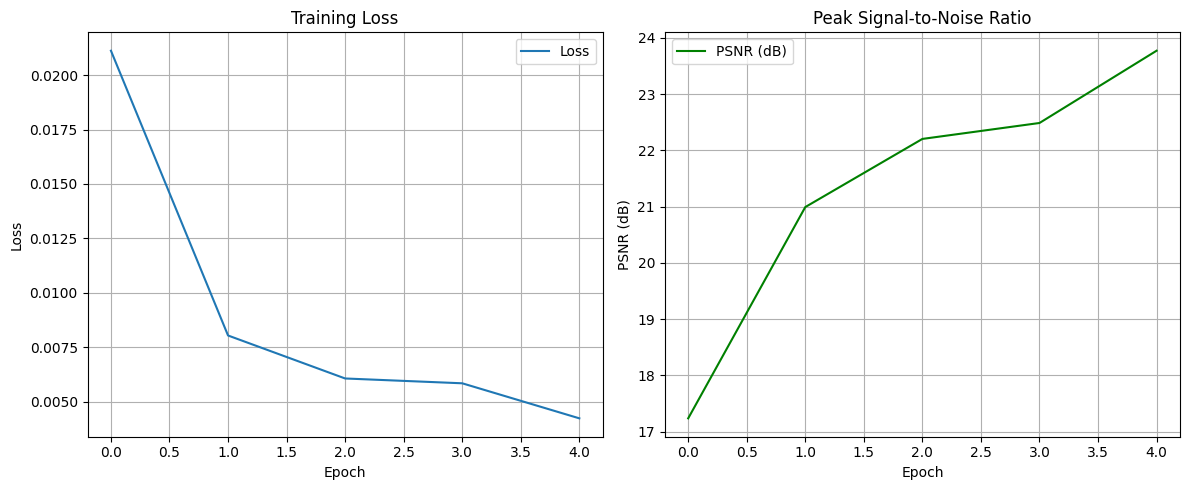


=== Hasil Training ===
Epoch 1: Loss = 0.021122, PSNR = 17.24 dB
Epoch 2: Loss = 0.008034, PSNR = 20.99 dB
Epoch 3: Loss = 0.006059, PSNR = 22.20 dB
Epoch 4: Loss = 0.005837, PSNR = 22.48 dB
Epoch 5: Loss = 0.004227, PSNR = 23.77 dB


In [ ]:
import matplotlib.pyplot as plt

# Anggap losses dan psnr_scores sudah terisi saat training selesai
# Jika belum, simpan nilai loss dan PSNR di training loop sebelumnya, seperti di contoh sebelumnya

# 1. Grafik Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

# 2. Grafik PSNR (Peak Signal-to-Noise Ratio)
plt.subplot(1, 2, 2)
plt.plot(psnr_scores, label="PSNR (dB)", color="green")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Peak Signal-to-Noise Ratio")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Menampilkan nilai Loss dan PSNR per epoch
print("\n=== Hasil Training ===")
for i, (loss, psnr) in enumerate(zip(losses, psnr_scores), 1):
    print(f"Epoch {i}: Loss = {loss:.6f}, PSNR = {psnr:.2f} dB")
